# ENSAE | Fairness in Machine Learning

## Course Project on Vogel et al. (2021): Learning Fair Scoring Functions: Bipartite Ranking under ROC-based Fairness Constraints

For the university course "Fairness in Machine Learning", this project on the paper from Vogel was conducted. A corresponding report about the paper exists. The report summarizes the main messages from the paper and provides some further comments.

This notebook (together with the other scripts in this repository) served for some experimentation with the code from Vogel et al. (2021). The authors code was taken and is used here in a simplified and version. It only takes the code which is necessary to plot the ROC curves This version does not take days to run. Instead, it allows to setup some models both with AUC-based and ROC-based fairness constraints and to plot the resulting ROC-curves.

### Here just a very short summary of the paper:

The paper explores fairness in bipartite ranking. Here, we need constraints other than those in binary classification with fairness constraints. It discusses existing constraints based on the AUC, so the area under the (ROC) curve. However, these constraints have some limitations and cannot ensure fairness consistently. Then, the authors come up with pointwise ROC-based fairness constraints, which make it possible to ensure fairness for different thresholds within a chosen interval of FPR (False Positive Rate) and TPR (True Positive Rate) values.

### This notebook contains:

**1. Implementations using the Adult Dataset (like the utilized datasets very common in the Fairness in ML community)**

- 1.1: Definition of a data loading function

- 1.2: Learning a scoring function without fairness constraints

- 1.3: Loading the data for the first model with a fairness constraint

- 1.4: Defining a method to get an instance of the model

- 1.5: Instantiating a model with AUC-based constraints

- 1.6: Fitting the data to the model

- 1.7: Evaluation

- 1.8: Learning a scoring function with ROC-based fairness constraints

- 1.9: Experimenting with different monitoring points

**2. Compas dataset**

- 2.1: Inter-group pairwise AUC fairness

- 2.2: ROC based fairness

**3. German credit dataset**

- 3.1: Background Negative Subgroup Positive (BNSP) AUC fairness

- 3.2: ROC based fairness

**4. Concluding comments**

## Package import

First, we need to import the required packages. That involves standard ML packages (including tensorflow) but also the models created by Vogel et al. (2021). Therefore it's necessary to make sure that the .py scripts defining the models are stored in the respective folder.

To prevent dependency issues, I recommend creating a new conda environment before installing the packages. Information on how to do that can be found under the following link: https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#activating-an-environment

In [1]:
# for loading the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# for learning a model without constraints
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# for instantiating the model
import tensorflow as tf
if int(tf.__version__.split(".")[0]) == 2:
    tf.compat.v1.disable_eager_execution()
    from models.tfv2_model_auc_cons import AUCCons
    from models.tfv2_model_ptw_cons import PtwCons
    from models.tfv2_model_other_auc_cons import (AUCConsBNSP,
                                                  AUCConsBPSN,
                                                  AUCConsXAUC)
else:
    from models.model_auc_cons import AUCCons
    from models.model_ptw_cons import PtwCons
    from models.model_other_auc_cons import (AUCConsBNSP,
                                             AUCConsBPSN,
                                             AUCConsXAUC)

# to define a path where the results are saved
import pathlib

# to find out how long the fitting takes
import datetime

# for plotting the ROC curve in the end
import matplotlib.pyplot as plt

# 1. Adult Dataset

The paper experiments with four different datasets, 3 out of which are implemented here. However, it can easily be adaped to further datasets.

## 1.1 Definition of a data loading function

It was a good idea to use the fit.py script from the original repository for orientation and to include the necessary components step for step in this notebook and the other folders of the repo. The code of this notebook contains rather little comments using a # as the authors have been very sparse with comments.

First, we need to define the function that loads the data. That is done with the load_adult_dataset() function from load_data.py. We define a function to load the other two datasets already here as well.

In [2]:
TEST_SIZE_COMPAS = 0.2
TEST_SIZE_GERMAN = 0.2

def load_adult_dataset():
    # The continuous variable fnlwgt represents final weight, which is the
    # number of units in the target population that the responding unit
    # represents.
    df_train = pd.read_csv("data/adult_dataset/adult.data", header=None)
    columns = ["age", "workclass", "fnlwgt", "education", "education-num",
               "marital-status", "occupation", "relationship", "race", "sex",
               "capital-gain", "capital-loss", "hours-per-week",
               "native-country", "salary"]
    df_train.columns = columns
    df_test = pd.read_csv("data/adult_dataset/adult.test", header=None, comment="|")
    df_test.columns = columns

    def proc_z(Z):
        return np.array([1 if "Male" in z else 0 for z in Z])

    def proc_y(Y):
        return np.array([1 if ">50K" in y else -1 for y in Y])

    Z_train, Z_test = [proc_z(s["sex"]) for s in [df_train, df_test]]
    Y_train, Y_test = [proc_y(s["salary"]) for s in [df_train, df_test]]

    col_quanti = ["age", "education-num", "capital-gain",
                  "capital-loss", "hours-per-week"]  # "fnlwgt",
    col_quali = ["workclass", "education", "marital-status", "occupation",
                 "relationship", "race", "sex", "native-country"]

    X_train_quali = df_train[col_quali].values
    X_test_quali = df_test[col_quali].values

    X_train_quanti = df_train[col_quanti]
    X_test_quanti = df_test[col_quanti]

    quali_encoder = OneHotEncoder(categories="auto")  # drop="first")
    quali_encoder.fit(X_train_quali)

    X_train_quali_enc = quali_encoder.transform(X_train_quali).toarray()
    X_test_quali_enc = quali_encoder.transform(X_test_quali).toarray()

    X_train = np.concatenate([X_train_quali_enc, X_train_quanti], axis=1)
    X_test = np.concatenate([X_test_quali_enc, X_test_quanti], axis=1)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (X_train, Y_train, Z_train), (X_test, Y_test, Z_test)


def load_compas_data():
    # See https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm
    # Load the two-year data
    df = pd.read_csv('data/compas_data/compas-scores-two-years.csv') # This path got adjusted so that we don't have too many subfolders

    # vr = violent recidivism
    # r = recidivism
    # Types of crimes in the USA: felonies and misdemeanors
    interesting_cols = [  # 'compas_screening_date',
        'sex',  # 'dob',
        'age', 'race',
        'juv_fel_count', 'decile_score', 'juv_misd_count',
        'juv_other_count', 'priors_count',
        'days_b_screening_arrest',
        'c_jail_in', 'c_jail_out',
        'c_charge_degree',
        'is_recid',
        'v_decile_score',
        'decile_score.1',
        ]
    df = df[interesting_cols]
    df = df[np.logical_and(df["days_b_screening_arrest"] >= -30,
                           df["days_b_screening_arrest"] <= 30)]
    df["days_in_jail"] = [a.days for a in (pd.to_datetime(df["c_jail_out"]) -
                                           pd.to_datetime(df["c_jail_in"]))]
    df = df[df["is_recid"] >= 0]
    df = df[df["c_charge_degree"] != "O"]
    # df = df[[x in {"Caucasian", "African-American"} for x in df["race"]]]
    Z = np.array([int(x == "African-American") for x in df["race"]])
    Y = 2*df["is_recid"].values - 1

    cols_to_delete = ["c_jail_out", "c_jail_in", "days_b_screening_arrest"]
    df = df[[a for a in df.columns if a not in cols_to_delete]]

    col_quanti = ["age", "juv_fel_count", "decile_score", "juv_misd_count",
                  "priors_count", "v_decile_score", "decile_score.1",
                  "days_in_jail"]
    col_quali = ["race", "c_charge_degree"]

    X_quali = df[col_quali].values
    X_quanti = df[col_quanti].values

    quali_encoder = OneHotEncoder(categories="auto")
    quali_encoder.fit(X_quali)

    X_quali = quali_encoder.transform(X_quali).toarray()

    X = np.concatenate([X_quanti, X_quali], axis=1)

    X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(
        X, Y, Z, test_size=TEST_SIZE_COMPAS, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (X_train, Y_train, Z_train), (X_test, Y_test, Z_test)


def load_german_data():
    def preprocess_z(x):
        assert x in {"A91", "A92", "A93", "A94", "A95"}
        if x in {"A91", "A93", "A94"}:
            return 1
        else:
            return 0

    def preprocess_y(x):
        assert x in {1, 2}
        return 2*int(x == 1) - 1

    # Generates a dataset with 48 covariates with
    df = pd.read_csv("data/german_credit_data/german.data", sep=" ",
                     header=None)
    df.columns = ["check account", "duration", "credit history", "purpose",
                  "credit amount", "savings/bonds", "employed since",
                  "installment rate", "status and sex",
                  "other debtor/guarantor", "residence since", "property",
                  "age", "other plans", "housing", "existing credits",
                  "job", "number liable people", "telephone",
                  "foreign worker", "credit decision"]
    ind_sex = 8
    Z = np.array([preprocess_z(x) for x in df[df.columns[ind_sex]]])
    Y = np.array([preprocess_y(x) for x in df[df.columns[-1]]])

    cols_X = df.columns[:-1]
    ind_quali = {0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19}
    ind_all = set(range(len(cols_X)))

    X_quanti = df[df.columns[list(ind_all.difference(ind_quali))]].values

    X_quali = df[df.columns[list(ind_quali)]].values

    quali_encoder = OneHotEncoder(categories="auto")
    quali_encoder.fit(X_quali)
    X_quali = quali_encoder.transform(X_quali).toarray()

    X = np.concatenate([X_quanti, X_quali], axis=1)

    X_train, X_test, Z_train, Z_test, Y_train, Y_test = train_test_split(
        X, Z, Y, test_size=TEST_SIZE_GERMAN, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (X_train, Y_train, Z_train), (X_test, Y_test, Z_test)

# In the following function, I removed all the other datasets as we're just trying out the compas dataset here
def load_db_by_name(db_name):
    if db_name == "german":
        return load_german_data()
    elif db_name == "adult":
        return load_adult_dataset()
    elif db_name == "compas":
        return load_compas_data()
    raise ValueError("Wrong db name...")

## 1.2 Learning a scoring function without fairness constraints

As this is done in the paper as well, we quickly want to learn scores without any fairness constraint. In this case, this is done using a basic Logistic Regression. Logistic regression models the probability that the target variable belongs to a particular class as a function of the independent variables. This is done using the logistic function or sigmoid function, which outputs values between 0 and 1. These output values can be interpreted as probabilities or scores.

In [3]:
data_train, data_test = load_db_by_name("adult")
X_train, Y_train, Z_train = data_train
X_test, Y_test, Z_test = data_test

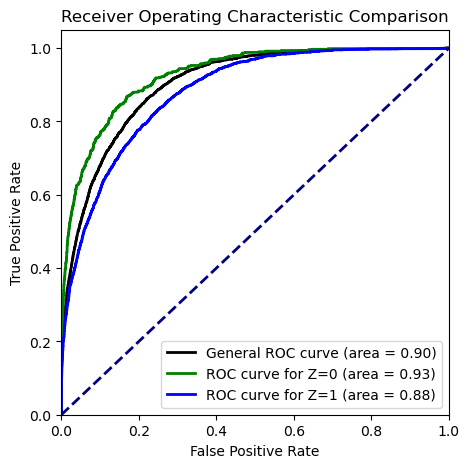

In [4]:
# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, Y_train)

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for all data
fpr, tpr, _ = roc_curve(Y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
lw = 2
plt.plot(fpr, tpr, color='black',
         lw=lw, label='General ROC curve (area = %0.2f)' % roc_auc)

# For ROC curves by group (e.g., Z=0 and Z=1)
colors = ['green', 'blue']
for idx, z_val in enumerate([0, 1]):
    # Use Z_test to filter X_test and y_test
    mask = Z_test == z_val
    X_test_z = X_test[mask]
    y_test_z = Y_test[mask]
    y_probs_z = model.predict_proba(X_test_z)[:, 1]
    
    fpr_z, tpr_z, _ = roc_curve(y_test_z, y_probs_z)
    roc_auc_z = auc(fpr_z, tpr_z)
    
    # Plot ROC curve for each subgroup
    plt.plot(fpr_z, tpr_z, color=colors[idx],
             lw=lw, label='ROC curve for Z={} (area = {:.2f})'.format(z_val, roc_auc_z))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Comparison')
plt.legend(loc="lower right")
plt.show()

This plot corresponds to Fig. 3g) in the paper. We can see that there are significantly more errors made for the group z = 1 (smaller AUC).

In the adult dataset, Z corresponds to the gender. z = 0 means female and z = 1 means male. Y indicates whether the individual earns $50K or more per year (y = 1 --> yes, y = 0 --> no).

After this quick plot, we continue with our work to learn scoring function with fairness constraints.

## 1.3 Loading the data for the first model with a fairness constraint

After calling the load_db_by_name() function, I just quickly output some instances of the data to verify that it's working.

In [5]:
time_1 = datetime.datetime.now()

data_train, data_test = load_db_by_name("adult")
X_train, Y_train, Z_train = data_train
X_test, Y_test, Z_test = data_test

# Print the first few rows of each part of the data to verify it's loaded correctly
print("First few rows of X_train:")
print(X_train[:2])

print("\nFirst few values of Z_train (sensitive attributes):")
print(Z_train[:2])

print("\nFirst few labels of y_train:")
print(Y_train[:2])

print("\nFirst few rows of X_test:")
print(X_test[:2])

print("\nFirst few values of Z_test (sensitive attributes):")
print(Z_test[:2])

print("\nFirst few labels of y_test:")
print(Y_test[:2])


First few rows of X_train:
[[-0.2444502  -0.17429511 -0.26209736 -0.01466381 -1.5167923  -0.18838933
  -0.29093568  4.90769968 -0.02073999 -0.17175325 -0.19348662 -0.11609195
  -0.07201601 -0.10164955 -0.1422718  -0.12664495 -0.18406376 -0.21053433
   2.25399324 -0.11334387 -0.68994199 -0.23637391 -0.03960742 -0.13419553
  -0.53714425 -0.39750806 -0.02658695 -0.92284068 -0.11403678  1.43105786
  -0.1802846  -0.17735813 -0.24494366  2.76348874 -0.01662771 -0.37949517
  -0.37774555 -0.17745022 -0.20957797 -0.25595432 -0.33554133 -0.06780164
  -0.38166338 -0.14260848 -0.35531609 -0.17127887 -0.22710355 -0.82533335
   1.70899099 -0.17624972 -0.42934582 -0.34403232 -0.22492681 -0.09820087
  -0.18155194 -0.32576824 -0.09161163  0.4130197  -0.70307135  0.70307135
  -0.13502327 -0.02416321 -0.06107342 -0.0480488  -0.04260602 -0.05409379
  -0.04641598 -0.02933708 -0.05714946 -0.05264698 -0.02985682 -0.06500204
  -0.02985682 -0.04437806 -0.03678503 -0.00554189 -0.01998525 -0.02479131
  -0.019985

## 1.4 Defining a method to get an instance of the model

Next in the fit.py script of the paper's repo, there's load_model() function which is called from the utils.py file. According to utils.py, this function returns and instantiation of the model.

For example acc. to model_auc_cons.py, we don't necessary need to hand over param_files when calling the load_model function as there are some default values defined in the model classes.

In [6]:
# Taking the relevant code for intantiating the model

# define a dictionary, mapping of model type identifiers to their corresponding class definitions
MODEL_PATH_TO_CLASS = {"auc_cons": AUCCons,
                       "auc_cons_bnsp": AUCConsBNSP,
                       "auc_cons_bpsn": AUCConsBPSN,
                       "auc_cons_xauc": AUCConsXAUC,
                       "ptw_cons": PtwCons}

# added **kwargs so that additional parameters would be allowed

def load_model(model_name, param_files=None, **kwargs):
    """Returns an instantiation of the model."""
    return MODEL_PATH_TO_CLASS[model_name](param_files=param_files, **kwargs)

## 1.5 Instantiating a model with AUC-based constraints

BPSN fairness stands for Background Negative Subgroup Positive (BNSP) fairness. This AUC-based constraint is relevant if you want the probabilties that a negative from a given group is mistakenly ranked higher than a positive to be the same across groups. The paper uses this constraint as non-recidivist individuals (negative) should be ranked higher than recidivist individuals (positive) with a low probability. This probability should not be higher (or theoretically lower) for African-American individuals than for any other individual.

In [7]:
xauc_model = load_model("auc_cons_xauc")

Parameters:
n_iter : 150000
n_batch : 1000
display_step : 10000
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0


In [8]:
# we hardcode a folder where the results are saved
exp_path = pathlib.Path("./output/adult_auc")

if not exp_path.exists():
    exp_path.mkdir(parents=True, exist_ok=True)

## 1.6 Fitting the data to the model

As we have loaded our custom model above, we can now fit it to our data. With 150,000 iterations (see on top of the script moel_auc_cons.py), this should take only a few minutes. There will be a print statement every 10,000 iterations.

In [9]:
# need to close an eventually already existing tenserflow session properly as we can't fit another model otherwise
tf.compat.v1.reset_default_graph()

time_2 = datetime.datetime.now()
xauc_model.fit(data_train) # I didn't include the optional parameter about the model folder as I just created a new instance.
time_3 = datetime.datetime.now()

Number of features: 107
Size of the train set: 29304
Size of the validation set: 3257
Instructions for updating:
Colocations handled automatically by placer.


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2024-05-10 13:35:43.732510: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Iter   0   ---------- 10/5/24 - 13:35:43 -----
Iter 10000 ---------- 10/5/24 - 13:36:6 -----
Iter 20000 ---------- 10/5/24 - 13:36:28 -----
Iter 30000 ---------- 10/5/24 - 13:36:51 -----
Iter 40000 ---------- 10/5/24 - 13:37:13 -----
Iter 50000 ---------- 10/5/24 - 13:37:36 -----
Iter 60000 ---------- 10/5/24 - 13:37:59 -----
Iter 70000 ---------- 10/5/24 - 13:38:22 -----
Iter 80000 ---------- 10/5/24 - 13:38:44 -----
Iter 90000 ---------- 10/5/24 - 13:39:7 -----
Iter 100000 ---------- 10/5/24 - 13:39:30 -----
Iter 110000 ---------- 10/5/24 - 13:39:52 -----
Iter 120000 ---------- 10/5/24 - 13:40:15 -----
Iter 130000 ---------- 10/5/24 - 13:40:38 -----
Iter 140000 ---------- 10/5/24 - 13:41:1 -----
Iter 149999 ---------- 10/5/24 - 13:41:24 -----


After fitting the model, we can simply output some information and save the model to the defined folder.

In [10]:
# Write a logging file with important info
with (exp_path / "log.txt").open("wt") as f:
    f.write("db_name: {}\n".format("adult"))
    f.write("time_to_load: {}\n".format(time_2-time_1))
    f.write("time_to_fit: {}\n".format(time_3-time_2))

# Save the model
xauc_model.save_model(exp_path)

## 1.7 Evaluation

Next, we use the model to create scores for the test set. The authors sometimes plot a ROC-curve for the train set as well. However, this is probably less relevant for this notebook.

In [11]:
s_test = np.array(xauc_model.score(X_test)).ravel().astype(float)
s_train = np.array(xauc_model.score(X_train)).ravel().astype(float)

# Define a path on where to save the results
path_analysis = pathlib.Path("./evaluation/adult_auc")

if not path_analysis.exists():
        path_analysis.mkdir(parents=True, exist_ok=True)

The following code is taken from ./more_utils/roc_calculus.py. Just like the cell after, it defines functions necessary to evaluate the results by defining how the FPR and TPR are calculated and how they are plotted.

In [12]:
def fpr_tpr(scores, classes):
    """
        Computes the ROC curves from scores and classes of comparisons.
        Does not work if the distributions of the scores are not continuous.
    """
    scores = np.array(scores)
    classes = (np.array(classes) == +1).astype(int)

    n_pos = classes.sum()
    n_neg = classes.shape[0] - n_pos

    ind_sort = np.argsort(scores)  # argsort, increasing order
    cl_sort = classes[ind_sort]

    fnr_ar = cl_sort.cumsum()/n_pos
    tnr_ar = (1-cl_sort).cumsum()/n_neg
    fpr_ar = 1 - tnr_ar

    return fpr_ar, 1 - fnr_ar

def auc(scores, classes, B=None):
    if B is None:
        s = scores.reshape((-1, 1))
        y = classes.reshape((-1, 1))
        ind_0, ind_1 = np.where((y-y.transpose()) > 0)
        delta_s = s[ind_0] - s[ind_1]
    else:
        s = scores
        y = classes
        f_p = (y == 1)
        s_p, s_n = s[f_p], s[~f_p]
        delta_s = np.random.choice(s_p, B) - np.random.choice(s_n, B)
    return (delta_s > 0).mean() + 0.5*(delta_s == 0).mean()

The following code is taken from ./more_utils/roc_plot.py and adjusted by leaving out unnecessary parts.

In [13]:
LEGEND_SIZE = (5.2, 1)


class RocGen:
    def __init__(self, s_1, s_2, out_fold):
        self.s_1 = s_1
        self.s_2 = s_2
        self.out_fold = out_fold
        self.prefix = ""

    def save_roc(self, fpr, tpr):
        fold = pathlib.Path("{}/{}".format(self.out_fold, "rocs"))
        if not fold.exists():
            fold.mkdir(parents=True, exist_ok=True)
        path = fold/("{}".format(self.prefix))
        with open(str(path) + "fpr.npy", "wb") as f:
            np.save(f, fpr)
        with open(str(path) + "tpr.npy", "wb") as f:
            np.save(f, tpr)


class RocGenSec3(RocGen):
    def f_1(self, y, z):
        return z == 0

    def f_2(self, y, z):
        return z == 1

    def y_1(self, y, z):
        return y[self.f_1(y, z)]

    def y_2(self, y, z):
        return y[self.f_2(y, z)]


class RocGenSec4(RocGen):
    def f_1(self, y, z):
        return y != 1

    def f_2(self, y, z):
        return y == 1

    def y_1(self, y, z):
        return z[self.f_1(y, z)]

    def y_2(self, y, z):
        return z[self.f_2(y, z)]


def plot_roc(s, y, z, rocgen, ls="-"):
    fpr, tpr = fpr_tpr(s, y)

    fpr_1, tpr_1 = fpr_tpr(s[rocgen.f_1(y, z)], rocgen.y_1(y, z))
    fpr_2, tpr_2 = fpr_tpr(s[rocgen.f_2(y, z)], rocgen.y_2(y, z))
    fpr, tpr = fpr_tpr(s, y)

    plt.plot(fpr_1, tpr_1, label=rocgen.s_1, color="green", linestyle=ls)
    plt.plot(fpr_2, tpr_2, label=rocgen.s_2, color="blue", linestyle=ls)
    plt.plot(fpr, tpr, label="$ROC_{H_s, G_s}$", color="black", linestyle=ls)

    orig_prefix = rocgen.prefix
    rocgen.prefix = orig_prefix + "-1-"
    rocgen.save_roc(fpr_1, tpr_1)
    rocgen.prefix = orig_prefix + "-2-"
    rocgen.save_roc(fpr_2, tpr_2)
    rocgen.prefix = orig_prefix + "-main-"
    rocgen.save_roc(fpr, tpr)


def legend_get_handles(ls="-"):
    handles = list()
    for color in ["green", "blue", "black"]:
        handles.append(plt.Line2D([0], [0], color=color, linestyle=ls))
    return handles


def plot_roc_sec3(path_analysis, data_train, data_test, save_data=True):
    s_train, y_train, Z_train = data_train
    s_test, y_test, Z_test = data_test

    plt.figure(figsize=(5, 5))

    s_1 = "$ROC_{H_s^{(0)}, G_s^{(0)}}$"
    s_2 = "$ROC_{H_s^{(1)}, G_s^{(1)}}$"
    rocgen = RocGenSec3(s_1, s_2, path_analysis)
    rocgen.prefix = "sec3-test"
    plot_roc(s_test, y_test, Z_test, rocgen)
    # rocgen.prefix = "sec3-train"
    # plot_roc(s_train, y_train, Z_train, rocgen, ls="--")

    plt.xlabel("$FPR$")
    plt.ylabel("$TPR$")
    plt.grid()
    plt.tight_layout()
    plt.savefig(path_analysis/"roc_sec3.pdf")

    plt.figure(figsize=LEGEND_SIZE)
    labels = [s_1, s_2, "$ROC_{H_s, G_s}$"]
    # leg = plt.legend(legend_get_handles("--"), labels, title="Train",
    #                  ncol=3, loc="center left")
    leg = plt.legend(legend_get_handles("-"), labels, title="Test",
               ncol=3, loc="center right") # added the leg = here in the beginning
    plt.gca().axis('off')
    plt.gca().add_artist(leg)
    plt.savefig(path_analysis/"leg_sec3.pdf")

    try:
        # Attempt to calculate the AUC and print it (doesn't seem to work if there are too little examples like in the german credit dataset)
        print(f"The AUC for the test (black ROC curve) set is: {auc(s_test, y_test):.3f}")
    except Exception as e:
        pass 


def plot_roc_sec4(path_analysis, data_train, data_test, save_data=True):
    s_train, y_train, Z_train = data_train
    s_test, y_test, Z_test = data_test

    plt.figure(figsize=(5, 5))

    plt.plot([0, 1], [0, 1], color="grey")
    s_1, s_2 = "$ROC_{H_s^{(0)}, H_s^{(1)}}$", "$ROC_{G_s^{(0)}, G_s^{(1)}}$"
    rocgen = RocGenSec4(s_1, s_2, path_analysis)
    rocgen.prefix = "sec4-test"
    plot_roc(s_test, y_test, Z_test, rocgen)
    # rocgen.prefix = "sec4-train"
    # plot_roc(s_train, y_train, Z_train, rocgen, ls="--")

    plt.xlabel("$FPR$")
    plt.ylabel("$TPR$")
    plt.grid()
    plt.tight_layout()
    plt.savefig(path_analysis/"roc_sec4.pdf")

    plt.figure(figsize=LEGEND_SIZE)
    labels = [s_1, s_2, "$ROC_{H_s, G_s}$"]
    # leg = plt.legend(legend_get_handles("--"), labels, title="Train",
    #                  ncol=3, loc="center left") # added the leg = here in the beginning
    leg = plt.legend(legend_get_handles("-"), labels, title="Test",
               ncol=3, loc="center right")
    plt.gca().axis('off')
    plt.gca().add_artist(leg)
    plt.savefig(path_analysis/"leg_sec4.pdf")

After defining these methods, we can simply call them and get our plots.

The plots corresponds to figure 3i) and 3j) in the paper. Here, clear similarities can be seen (also for the ROC-based constraints down below). However the rather low performance (low AUC value) shows that the models are indeed not as well finetuned as in the paper.

The AUC for the test (black ROC curve) set is: 0.831


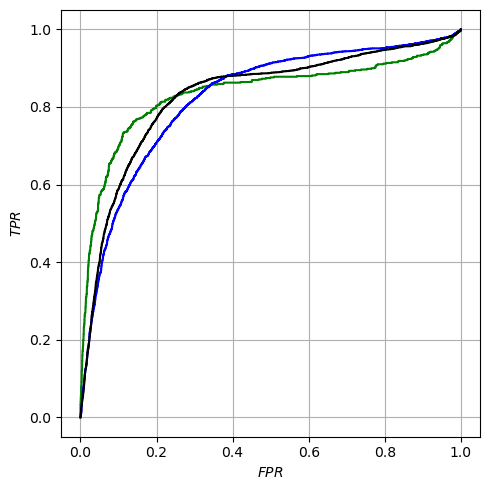

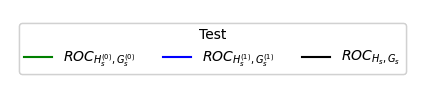

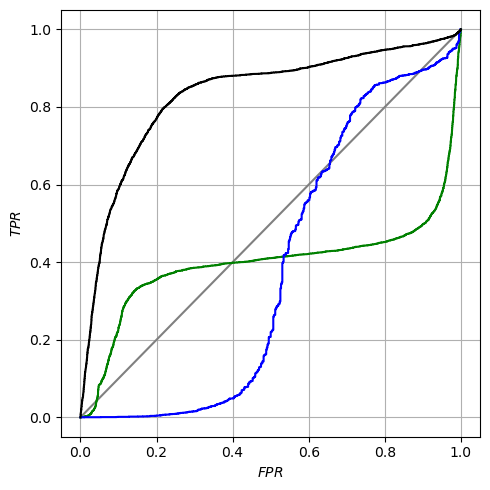

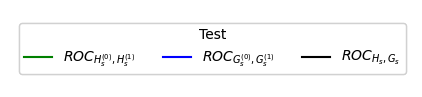

In [14]:
# 1. Plot ROC curves for all problems on the same plot
plot_roc_sec3(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Other view on ROCs
plot_roc_sec4(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

## 1.8 Learning a scoring function with ROC-based fairness constraints

Next, we can deal with the actual topic of the paper - the ROC-based constraints. Now, we load another model that inherits from the class AUCCons and adjusts it a bit. For example, there is the DEF_MON_PTS variable in this class. This seems to be indicating the monitoring points for the fairness metrics. (For models with ROC-based fairness constraint, it's possible to specify in which area of thresholds the scoring function should be fair). However, the default value of 0.25 doesn't need to be changed as this value is plausible according to the paper. But for other datasets, it might require adjustment.

Besides that, the code is pretty much the same as above. Only the model is adapted to roc_model whereever required.

In [15]:
roc_model = load_model("ptw_cons")

Parameters:
mon_pts : {-1: [0.25], 1: [0.25]}
adapt_step_t : 0.01
n_iter : 150000
n_batch : 1000
display_step : 10000
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0


In [16]:
# we hardcode a folder where the results are saved
exp_path = pathlib.Path("./output/adult_roc")

if not exp_path.exists():
    exp_path.mkdir(parents=True, exist_ok=True)

In [17]:
# need to close an eventually already existing tenserflow session properly as we can't fit another model otherwise
tf.compat.v1.reset_default_graph()

time_2 = datetime.datetime.now()
roc_model.fit(data_train) # I didn't include the optional parameter about the model folder as I just created a new instance.
time_3 = datetime.datetime.now()

Number of features: 107
Size of the train set: 29304
Size of the validation set: 3257


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Iter   0   ---------- 10/5/24 - 13:41:26 -----
Iter 10000 ---------- 10/5/24 - 13:41:48 -----
Iter 20000 ---------- 10/5/24 - 13:42:10 -----
Iter 30000 ---------- 10/5/24 - 13:42:31 -----
Iter 40000 ---------- 10/5/24 - 13:42:52 -----
Iter 50000 ---------- 10/5/24 - 13:43:13 -----
Iter 60000 ---------- 10/5/24 - 13:43:35 -----
Iter 70000 ---------- 10/5/24 - 13:43:56 -----
Iter 80000 ---------- 10/5/24 - 13:44:17 -----
Iter 90000 ---------- 10/5/24 - 13:44:39 -----
Iter 100000 ---------- 10/5/24 - 13:45:0 -----
Iter 110000 ---------- 10/5/24 - 13:45:21 -----
Iter 120000 ---------- 10/5/24 - 13:45:43 -----
Iter 130000 ---------- 10/5/24 - 13:46:4 -----
Iter 140000 ---------- 10/5/24 - 13:46:25 -----
Iter 149999 ---------- 10/5/24 - 13:46:47 -----


In [18]:
# Write a logging file with important info
with (exp_path / "log.txt").open("wt") as f:
    f.write("db_name: {}\n".format("adult"))
    f.write("time_to_load: {}\n".format(time_2-time_1))
    f.write("time_to_fit: {}\n".format(time_3-time_2))

# Save the model
roc_model.save_model(exp_path)

In [19]:
s_test = np.array(roc_model.score(X_test)).ravel().astype(float)
s_train = np.array(roc_model.score(X_train)).ravel().astype(float)

# Define a path on where to save the results
path_analysis = pathlib.Path("./evaluation/adult_roc")

if not path_analysis.exists():
        path_analysis.mkdir(parents=True, exist_ok=True)

When creating the following plot and comparing it to the above plots with AUC-constraints, we should see that the two groups (green and blue) should deviate less from each other in the areas with low TPR / FPR and more in areas with a higher threshold (so areas, that are anyways having too many false positives and that are therefore not relevant).

The plots corresponds to figure 3k) and 3l) in the paper.

The AUC for the test (black ROC curve) set is: 0.812


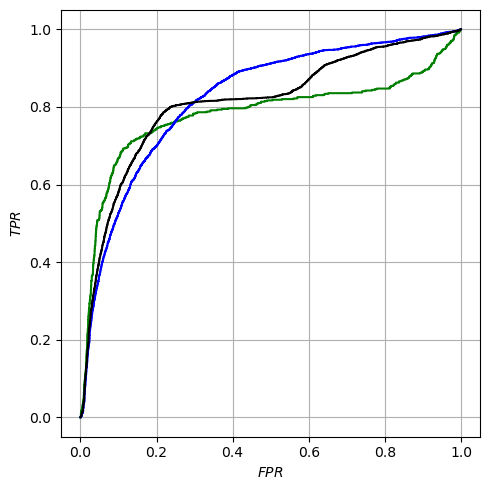

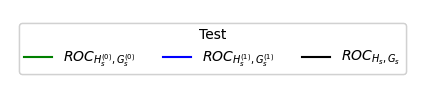

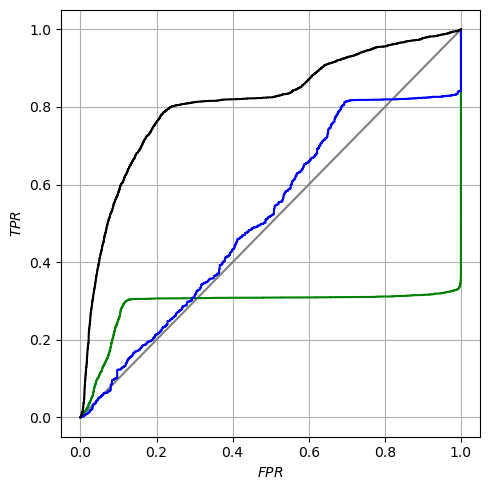

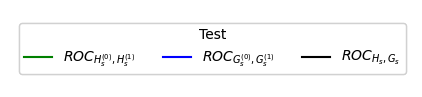

In [20]:
# 1. Plot ROC curves for all problems on the same plot
plot_roc_sec3(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Other view on ROCs
plot_roc_sec4(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

## 1.9 Experimenting with different monitoring points

Next, I would like to conduct some small experiment with different monitoring points for the model using ROC-based constraints. The load_model() function as well as the constructor of the model were adapted in a way that different monitoring points could be handed over directly and that it's no longer required to have a JSON with the parameters. The monitoring points seem to indicate in which (threshold) ares the model should specifically ensure fairness between the two groups. However, the monitoring points do not seem to represent a specific variable from the theoretical learning problem. The authors state in their paper that the implemented algorithms differ to a certain degree from the theoretical ones. This section aims to find out how the ROC curves behave depending on different monitoring points.

We simply define the different monitoring points and than train a model with different monitoring points in each iteration of the loop. We save the resulting data and create all the plots in the end.

Parameters:
mon_pts : {-1: [0.1], 1: [0.1]}
adapt_step_t : 0.01
n_iter : 150000
n_batch : 1000
display_step : 10000
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0
Number of features: 107
Size of the train set: 29304
Size of the validation set: 3257


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Iter   0   ---------- 10/5/24 - 13:46:49 -----
Iter 10000 ---------- 10/5/24 - 13:47:12 -----
Iter 20000 ---------- 10/5/24 - 13:47:34 -----
Iter 30000 ---------- 10/5/24 - 13:47:56 -----
Iter 40000 ---------- 10/5/24 - 13:48:20 -----
Iter 50000 ---------- 10/5/24 - 13:48:43 -----
Iter 60000 ---------- 10/5/24 - 13:49:6 -----
Iter 70000 ---------- 10/5/24 - 13:49:28 -----
Iter 80000 ---------- 10/5/24 - 13:49:50 -----
Iter 90000 ---------- 10/5/24 - 13:50:13 -----
Iter 100000 ---------- 10/5/24 - 13:50:35 -----
Iter 110000 ---------- 10/5/24 - 13:50:58 -----
Iter 120000 ---------- 10/5/24 - 13:51:20 -----
Iter 130000 ---------- 10/5/24 - 13:51:43 -----
Iter 140000 ---------- 10/5/24 - 13:52:5 -----
Iter 149999 ---------- 10/5/24 - 13:52:28 -----
Parameters:
mon_pts : {-1: [0.2], 1: [0.2]}
adapt_step_t : 0.01
n_iter : 150000
n_batch : 1000
display_step : 10000
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun 

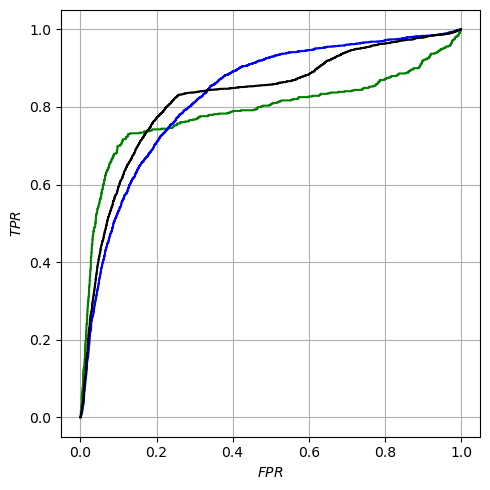

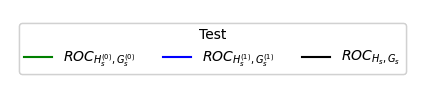

Plotting intra-group ROC for monitoring points: {-1: [0.2], 1: [0.2]}
The AUC for the test (black ROC curve) set is: 0.838


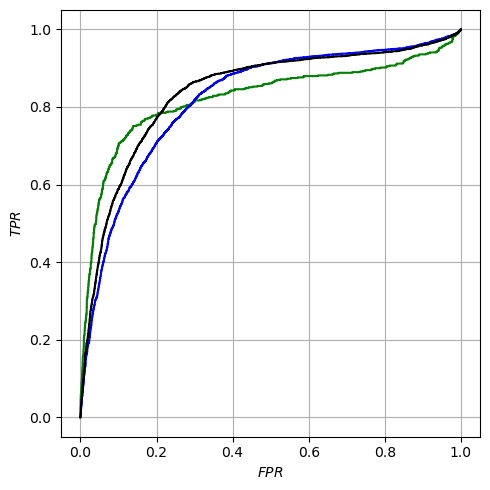

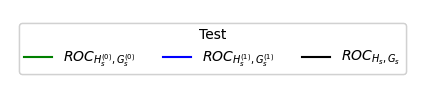

Plotting intra-group ROC for monitoring points: {-1: [0.3], 1: [0.3]}
The AUC for the test (black ROC curve) set is: 0.815


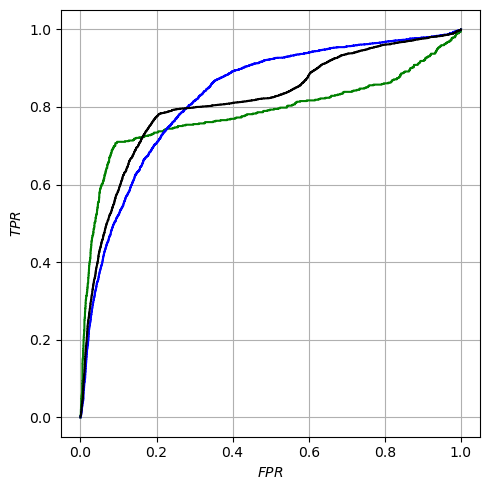

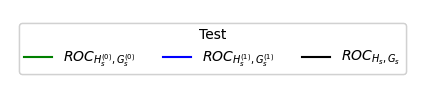

Plotting intra-group ROC for monitoring points: {-1: [0.4], 1: [0.4]}
The AUC for the test (black ROC curve) set is: 0.840


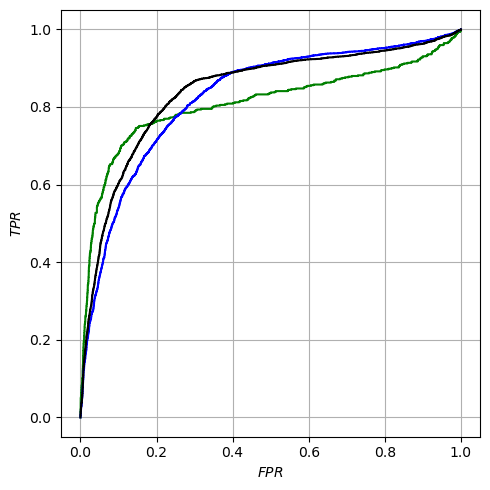

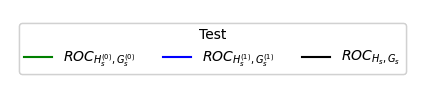

Plotting intra-group ROC for monitoring points: {-1: [0.5], 1: [0.5]}
The AUC for the test (black ROC curve) set is: 0.836


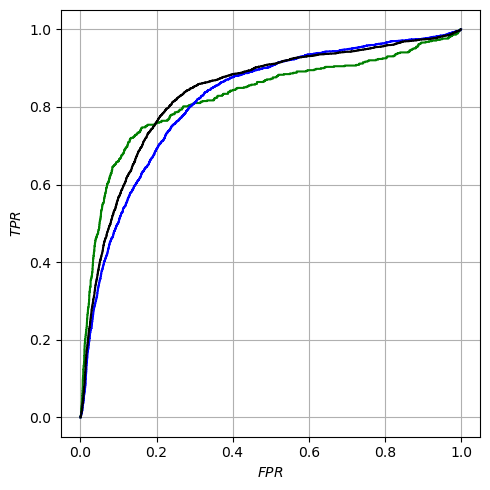

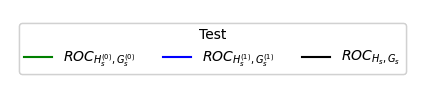

Plotting inter-group ROC for monitoring points: {-1: [0.1], 1: [0.1]}


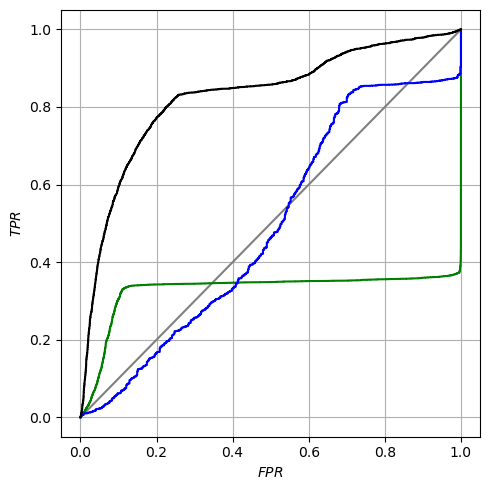

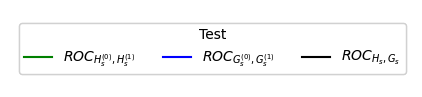

Plotting inter-group ROC for monitoring points: {-1: [0.2], 1: [0.2]}


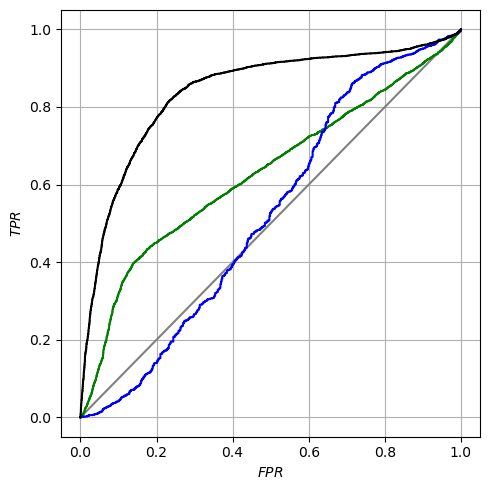

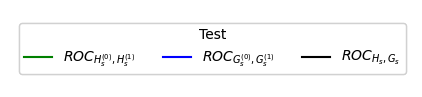

Plotting inter-group ROC for monitoring points: {-1: [0.3], 1: [0.3]}


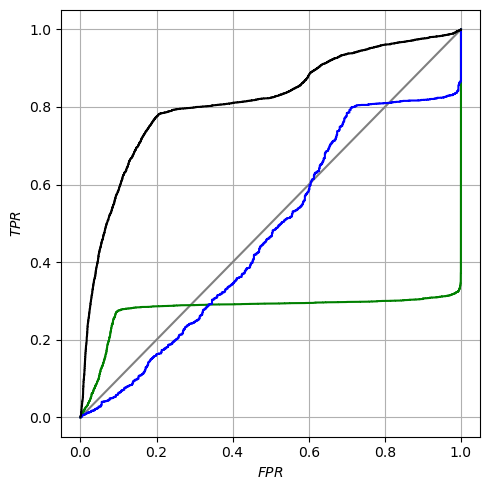

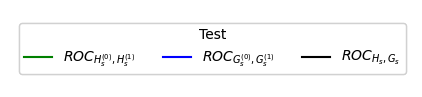

Plotting inter-group ROC for monitoring points: {-1: [0.4], 1: [0.4]}


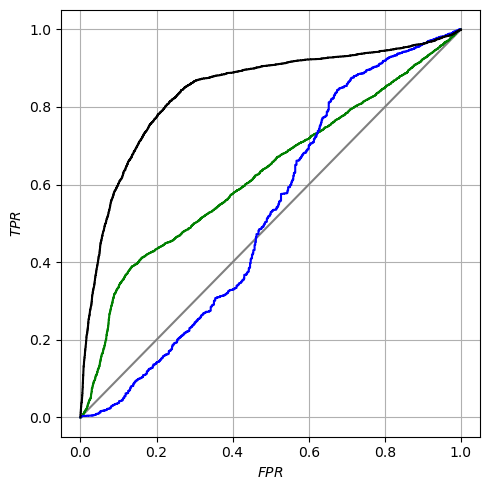

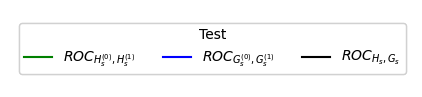

Plotting inter-group ROC for monitoring points: {-1: [0.5], 1: [0.5]}


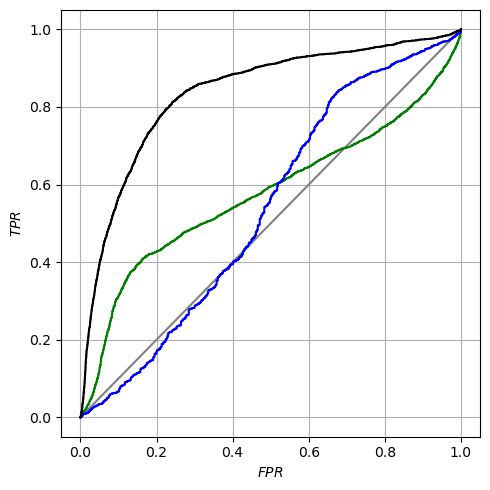

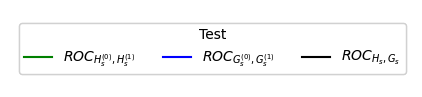

In [21]:
# Here we define different monitoring points that we want to plot
mon_pts_variants = [
    {-1: [0.1], +1: [0.1]},
    {-1: [0.2], +1: [0.2]},
    {-1: [0.3], +1: [0.3]},
    {-1: [0.4], +1: [0.4]},
    {-1: [0.5], +1: [0.5]}
]

# Directory for outputs
exp_path = pathlib.Path("./output/experiment_1")
if not exp_path.exists():
    exp_path.mkdir(parents=True, exist_ok=True)

# Storage for scores and ROC data
roc_data_sec3 = []
roc_data_sec4 = []

for idx, mon_pts in enumerate(mon_pts_variants):
    # Reset TensorFlow graph to avoid clutter from previous models
    tf.compat.v1.reset_default_graph()

    # Load and fit the model
    model = load_model("ptw_cons", mon_pts=mon_pts)
    model.fit(data_train)

    # Evaluate the model
    s_test = np.array(model.score(X_test)).ravel().astype(float)
    s_train = np.array(model.score(X_train)).ravel().astype(float)

    # Store results for later plotting
    roc_data_sec3.append((s_train, Y_train, Z_train, s_test, Y_test, Z_test))
    roc_data_sec4.append((s_train, Y_train, Z_train, s_test, Y_test, Z_test))

    # Save the model
    model_path = exp_path / f"model_mon_pts_{idx}"
    if not model_path.exists():
        model_path.mkdir(parents=True, exist_ok=True)
    model.save_model(model_path)

# Plotting all ROC curves after training all models
path_analysis = exp_path / "evaluation/experiment_1"
if not path_analysis.exists():
    path_analysis.mkdir(parents=True, exist_ok=True)

i = 0
for data in roc_data_sec3:
    print(f'Plotting intra-group ROC for monitoring points: {mon_pts_variants[i]}')
    plot_roc_sec3(path_analysis, (data[0], data[1], data[2]), (data[3], data[4], data[5]))
    plt.show()  # This will force the plot to display immediately
    i += 1

i = 0
for data in roc_data_sec4:
    print(f'Plotting inter-group ROC for monitoring points: {mon_pts_variants[i]}')
    plot_roc_sec4(path_analysis, (data[0], data[1], data[2]), (data[3], data[4], data[5]))
    plt.show()  # This will force the plot to display immediately
    i += 1

Interestingly, the ROC curves (especially in green) look similar for the monitoring points 0.1 and 0.3 and rather similar for all the others. Therefore, I cannot really detect any pattern in the results.

Parameters:
mon_pts : {-1: [0.1], 1: [0.3]}
adapt_step_t : 0.01
n_iter : 150000
n_batch : 1000
display_step : 10000
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0
Number of features: 107
Size of the train set: 29304
Size of the validation set: 3257
Iter   0   ---------- 10/5/24 - 14:27:43 -----
Iter 10000 ---------- 10/5/24 - 14:28:6 -----
Iter 20000 ---------- 10/5/24 - 14:28:29 -----
Iter 30000 ---------- 10/5/24 - 14:28:51 -----
Iter 40000 ---------- 10/5/24 - 14:29:14 -----
Iter 50000 ---------- 10/5/24 - 14:29:36 -----
Iter 60000 ---------- 10/5/24 - 14:29:58 -----
Iter 70000 ---------- 10/5/24 - 14:30:20 -----
Iter 80000 ---------- 10/5/24 - 14:30:43 -----
Iter 90000 ---------- 10/5/24 - 14:31:5 -----
Iter

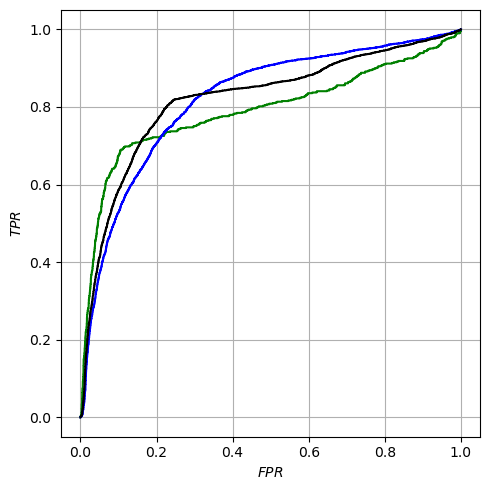

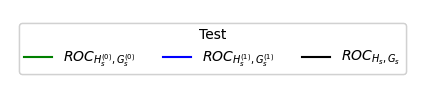

Plotting intra-group ROC for monitoring points: {-1: [0.3], 1: [0.1]}
The AUC for the test (black ROC curve) set is: 0.825


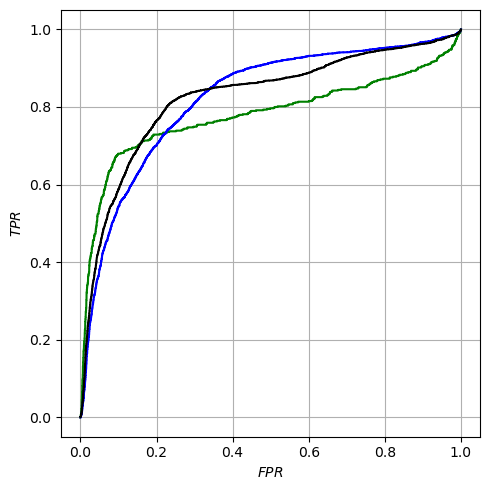

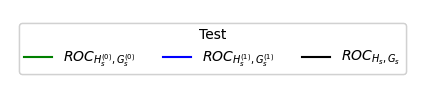

Plotting inter-group ROC for monitoring points: {-1: [0.1], 1: [0.3]}


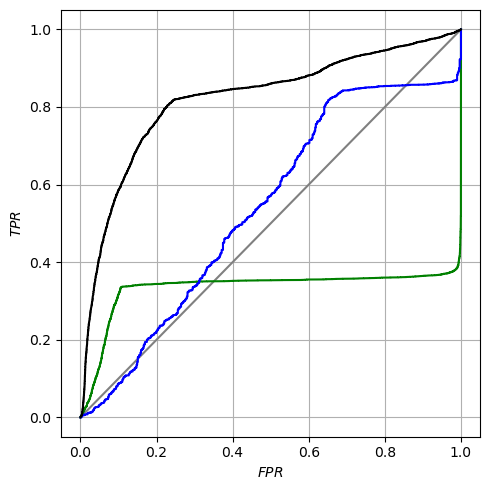

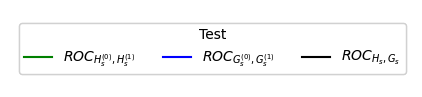

Plotting inter-group ROC for monitoring points: {-1: [0.3], 1: [0.1]}


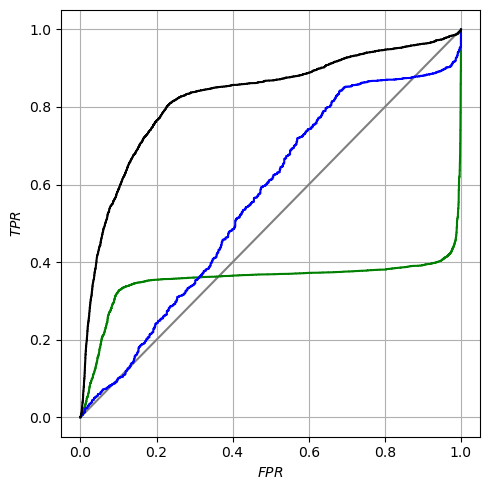

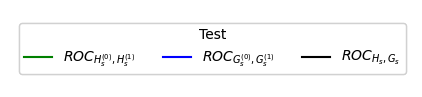

In [23]:
# Here we define different monitoring points that we want to plot
mon_pts_variants = [
    {-1: [0.1], +1: [0.3]},
    {-1: [0.3], +1: [0.1]}
]

# Directory for outputs
exp_path = pathlib.Path("./output/experiment_2")
if not exp_path.exists():
    exp_path.mkdir(parents=True, exist_ok=True)

# Storage for scores and ROC data
roc_data_sec3 = []
roc_data_sec4 = []

for idx, mon_pts in enumerate(mon_pts_variants):
    # Reset TensorFlow graph to avoid clutter from previous models
    tf.compat.v1.reset_default_graph()

    # Load and fit the model
    model = load_model("ptw_cons", mon_pts=mon_pts)
    model.fit(data_train)

    # Evaluate the model
    s_test = np.array(model.score(X_test)).ravel().astype(float)
    s_train = np.array(model.score(X_train)).ravel().astype(float)

    # Store results for later plotting
    roc_data_sec3.append((s_train, Y_train, Z_train, s_test, Y_test, Z_test))
    roc_data_sec4.append((s_train, Y_train, Z_train, s_test, Y_test, Z_test))

    # Save the model
    model_path = exp_path / f"model_mon_pts_{idx}"
    if not model_path.exists():
        model_path.mkdir(parents=True, exist_ok=True)
    model.save_model(model_path)

# Plotting all ROC curves after training all models
path_analysis = exp_path / "evaluation/experiment_2"
if not path_analysis.exists():
    path_analysis.mkdir(parents=True, exist_ok=True)

i = 0
for data in roc_data_sec3:
    print(f'Plotting intra-group ROC for monitoring points: {mon_pts_variants[i]}')
    plot_roc_sec3(path_analysis, (data[0], data[1], data[2]), (data[3], data[4], data[5]))
    plt.show()  # This will force the plot to display immediately
    i += 1

i = 0
for data in roc_data_sec4:
    print(f'Plotting inter-group ROC for monitoring points: {mon_pts_variants[i]}')
    plot_roc_sec4(path_analysis, (data[0], data[1], data[2]), (data[3], data[4], data[5]))
    plt.show()  # This will force the plot to display immediately
    i += 1

Here, we particularly notice the bend in the green curve at FPR = 0.1 for the monitoring points -1: [0.1], 1: [0.3]. Besides that, the plots look very similar.

Next, we are using some random values between 0.1 and 0.5 as monitoring points.

Parameters:
mon_pts : {-1: [0.2889948052995033], 1: [0.48600412669417303]}
adapt_step_t : 0.01
n_iter : 150000
n_batch : 1000
display_step : 10000
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0
Number of features: 107
Size of the train set: 29304
Size of the validation set: 3257


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Iter   0   ---------- 10/5/24 - 14:41:22 -----
Iter 10000 ---------- 10/5/24 - 14:41:46 -----
Iter 20000 ---------- 10/5/24 - 14:42:9 -----
Iter 30000 ---------- 10/5/24 - 14:42:33 -----
Iter 40000 ---------- 10/5/24 - 14:42:56 -----
Iter 50000 ---------- 10/5/24 - 14:43:19 -----
Iter 60000 ---------- 10/5/24 - 14:43:43 -----
Iter 70000 ---------- 10/5/24 - 14:44:6 -----
Iter 80000 ---------- 10/5/24 - 14:44:29 -----
Iter 90000 ---------- 10/5/24 - 14:44:52 -----
Iter 100000 ---------- 10/5/24 - 14:45:15 -----
Iter 110000 ---------- 10/5/24 - 14:45:38 -----
Iter 120000 ---------- 10/5/24 - 14:46:1 -----
Iter 130000 ---------- 10/5/24 - 14:46:24 -----
Iter 140000 ---------- 10/5/24 - 14:46:47 -----
Iter 149999 ---------- 10/5/24 - 14:47:10 -----
Parameters:
mon_pts : {-1: [0.2449913075367512], 1: [0.18995675768493353]}
adapt_step_t : 0.01
n_iter : 150000
n_batch : 1000
display_step : 10000
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
op

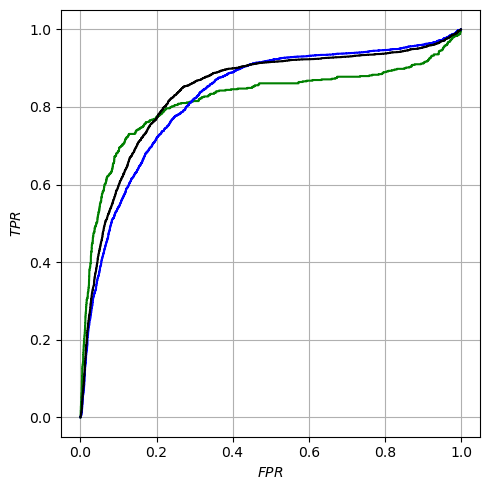

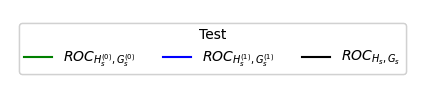

Plotting intra-group ROC for monitoring points: {-1: [0.2449913075367512], 1: [0.18995675768493353]}
The AUC for the test (black ROC curve) set is: 0.824


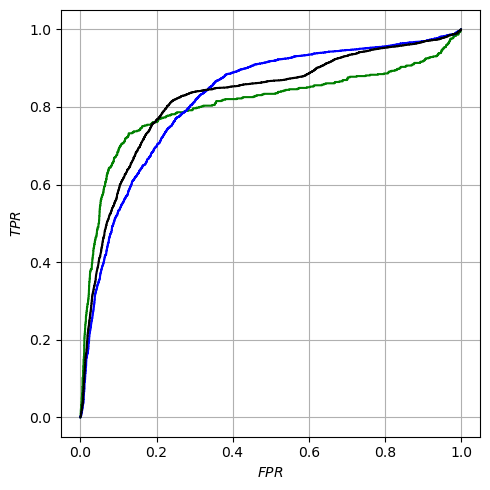

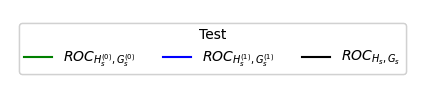

Plotting intra-group ROC for monitoring points: {-1: [0.41654606194833166], 1: [0.29728178590689147]}
The AUC for the test (black ROC curve) set is: 0.829


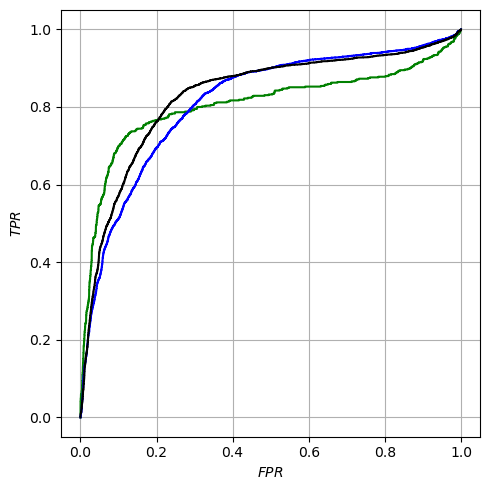

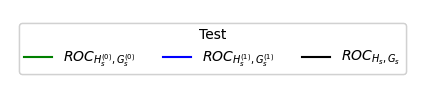

Plotting intra-group ROC for monitoring points: {-1: [0.1277343808789551], 1: [0.43920655920009644]}
The AUC for the test (black ROC curve) set is: 0.819


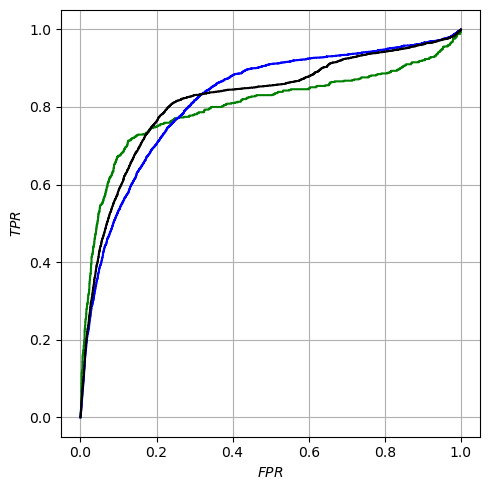

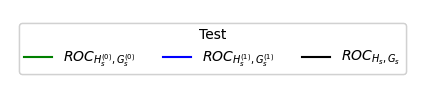

Plotting intra-group ROC for monitoring points: {-1: [0.3378347949126451], 1: [0.2491349475216172]}
The AUC for the test (black ROC curve) set is: 0.835


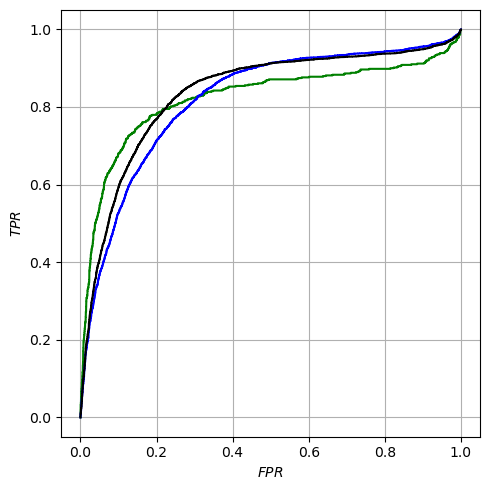

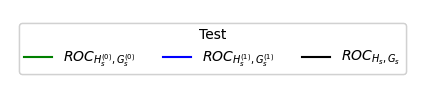

Plotting inter-group ROC for monitoring points: {-1: [0.2889948052995033], 1: [0.48600412669417303]}


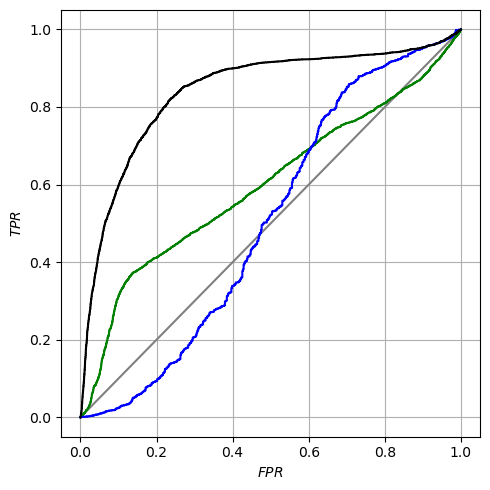

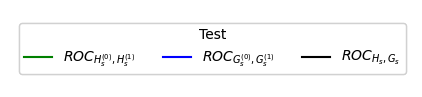

Plotting inter-group ROC for monitoring points: {-1: [0.2449913075367512], 1: [0.18995675768493353]}


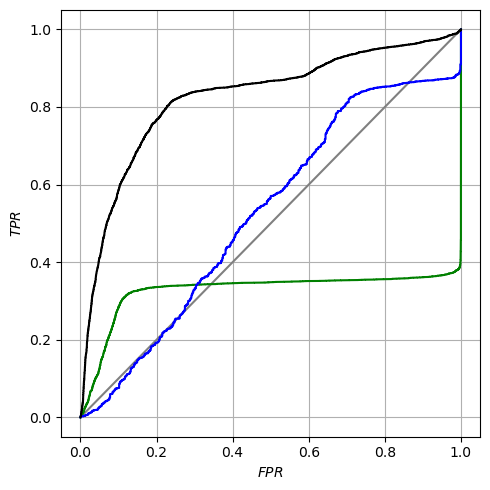

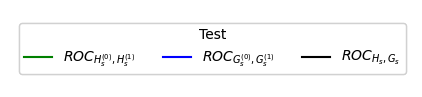

Plotting inter-group ROC for monitoring points: {-1: [0.41654606194833166], 1: [0.29728178590689147]}


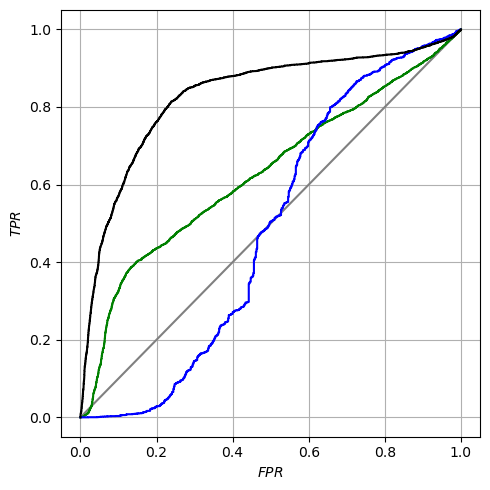

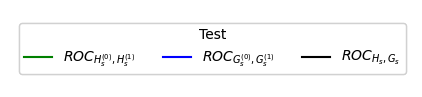

Plotting inter-group ROC for monitoring points: {-1: [0.1277343808789551], 1: [0.43920655920009644]}


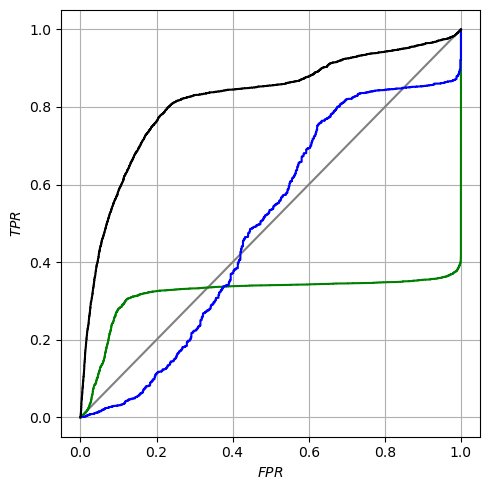

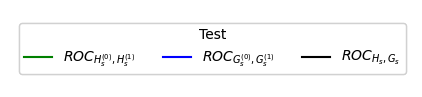

Plotting inter-group ROC for monitoring points: {-1: [0.3378347949126451], 1: [0.2491349475216172]}


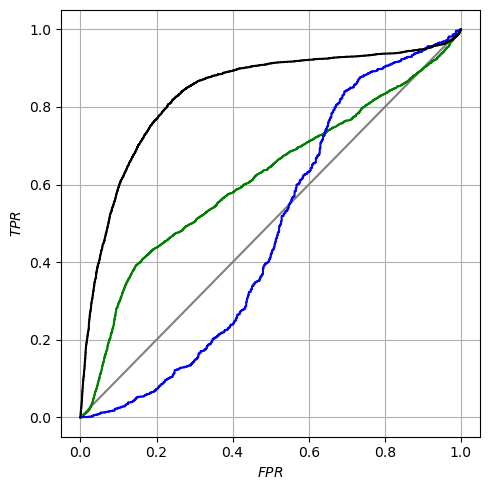

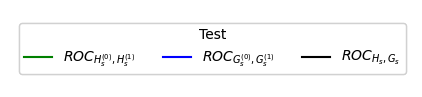

In [24]:
# Here we define different monitoring points that we want to plot
mon_pts_variants = [{-1: [np.random.uniform(0.1, 0.5)], +1: [np.random.uniform(0.1, 0.5)]} for _ in range(5)]

# Directory for outputs
exp_path = pathlib.Path("./output/experiment_3")
if not exp_path.exists():
    exp_path.mkdir(parents=True, exist_ok=True)

# Storage for scores and ROC data
roc_data_sec3 = []
roc_data_sec4 = []

for idx, mon_pts in enumerate(mon_pts_variants):
    # Reset TensorFlow graph to avoid clutter from previous models
    tf.compat.v1.reset_default_graph()

    # Load and fit the model
    model = load_model("ptw_cons", mon_pts=mon_pts)
    model.fit(data_train)

    # Evaluate the model
    s_test = np.array(model.score(X_test)).ravel().astype(float)
    s_train = np.array(model.score(X_train)).ravel().astype(float)

    # Store results for later plotting
    roc_data_sec3.append((s_train, Y_train, Z_train, s_test, Y_test, Z_test))
    roc_data_sec4.append((s_train, Y_train, Z_train, s_test, Y_test, Z_test))

    # Save the model
    model_path = exp_path / f"model_mon_pts_{idx}"
    if not model_path.exists():
        model_path.mkdir(parents=True, exist_ok=True)
    model.save_model(model_path)

# Plotting all ROC curves after training all models
path_analysis = exp_path / "evaluation/experiment_3"
if not path_analysis.exists():
    path_analysis.mkdir(parents=True, exist_ok=True)

i = 0
for data in roc_data_sec3:
    print(f'Plotting intra-group ROC for monitoring points: {mon_pts_variants[i]}')
    plot_roc_sec3(path_analysis, (data[0], data[1], data[2]), (data[3], data[4], data[5]))
    plt.show()  # This will force the plot to display immediately
    i += 1

i = 0
for data in roc_data_sec4:
    print(f'Plotting inter-group ROC for monitoring points: {mon_pts_variants[i]}')
    plot_roc_sec4(path_analysis, (data[0], data[1], data[2]), (data[3], data[4], data[5]))
    plt.show()  # This will force the plot to display immediately
    i += 1

Unfortunately, we still do not know the actual influence of the monitoring points on the adaptive learning. Further experiments are required as we cannot detect any patterns. Further experimentation or further understanding of the details of the apdaptive learning would be necessary.

But we can see once more that even though the intra-group ROC curves (first 5 diagrams) look rather similar, the resulting inter-group ROC curves can differ significantly. We should therefore highlight that it is important to look at the fairness in detail and that plotting the intra-group ROC curves might not be enough.

# 2. Compas dataset

The code from above is just utilized to learn some scoring functions for the adult dataset and in section 3 for the german credit dataset. Here, I abandon extensive comments and put all the necessary code together in a few cells.

In [25]:
time_1 = datetime.datetime.now()

data_train, data_test = load_db_by_name("compas")
X_train, Y_train, Z_train = data_train
X_test, Y_test, Z_test = data_test

# Print the first few rows of each part of the data to verify it's loaded correctly
print("First few rows of X_train:")
print(X_train[:3])

print("\nFirst few values of Z_train (sensitive attributes):")
print(Z_train[:3])

print("\nFirst few labels of y_train:")
print(Y_train[:3])

print("\nFirst few rows of X_test:")
print(X_test[:3])

print("\nFirst few values of Z_test (sensitive attributes):")
print(Z_test[:3])

print("\nFirst few labels of y_test:")
print(Y_test[:3])

First few rows of X_train:
[[ 0.45923617 -0.1257918  -1.20229829 -0.18721999 -0.69278746 -1.05870501
  -1.20229829 -0.3137581  -1.03820131 -0.07552357  1.41206789 -0.30054426
  -0.04028706 -0.24613009 -1.35248895  1.35248895]
 [-0.82140605 -0.1257918  -0.14667911 -0.18721999 -0.4813843  -0.25612127
  -0.14667911 -0.29195745 -1.03820131 -0.07552357 -0.70818125 -0.30054426
  -0.04028706  4.0628921   0.73937757 -0.73937757]
 [ 0.11773158 -0.1257918   0.55706701 -0.18721999  1.63264728  0.14517061
   0.55706701 -0.27015679 -1.03820131 -0.07552357  1.41206789 -0.30054426
  -0.04028706 -0.24613009 -1.35248895  1.35248895]]

First few values of Z_train (sensitive attributes):
[0 0 0]

First few labels of y_train:
[-1  1  1]

First few rows of X_test:
[[-0.7360299  -0.1257918   1.96455926 -0.18721999  2.0554536   2.55292183
   1.96455926 -0.16115352  0.96320434 -0.07552357 -0.70818125 -0.30054426
  -0.04028706 -0.24613009 -1.35248895  1.35248895]
 [-0.30914916 -0.1257918  -0.49855217  1.857702

## 2.1 Background Positive Subgroup Negative (BPSN) AUC fairness

BPSN fairness stands for Background Positive Subgroup Negative fairness. This AUC-based constraint is relevant if you want the probabilties that a negative from a given group is mistakenly ranked higher than a positive to be the same across groups. The paper uses this constraint as non-recidivist individuals (negative) should be ranked higher than recidivist individuals (positive) with a low probability. This probability should not be higher (or theoretically lower) for African-American individuals than for any other individual.

The two plots which were generated are now corresponding to figure 3c) and 3d) in the paper. We see that there are certainly some deviations to those in the paper. However, the authors fitted all the models very very often, used averages, best hyperparameters etc. That is not possible here due to resource constraints. It also should be mentioned here that there is a certain degree of randomness. That implies that the curves would look different every time this notebook is run.

Parameters:
n_iter : 150000
n_batch : 1000
display_step : 10000
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0
Number of features: 16
Size of the train set: 4443
Size of the validation set: 494


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Iter   0   ---------- 10/5/24 - 15:9:1 -----
Iter 10000 ---------- 10/5/24 - 15:9:10 -----
Iter 20000 ---------- 10/5/24 - 15:9:18 -----
Iter 30000 ---------- 10/5/24 - 15:9:26 -----
Iter 40000 ---------- 10/5/24 - 15:9:35 -----
Iter 50000 ---------- 10/5/24 - 15:9:43 -----
Iter 60000 ---------- 10/5/24 - 15:9:51 -----
Iter 70000 ---------- 10/5/24 - 15:9:59 -----
Iter 80000 ---------- 10/5/24 - 15:10:7 -----
Iter 90000 ---------- 10/5/24 - 15:10:16 -----
Iter 100000 ---------- 10/5/24 - 15:10:24 -----
Iter 110000 ---------- 10/5/24 - 15:10:32 -----
Iter 120000 ---------- 10/5/24 - 15:10:40 -----
Iter 130000 ---------- 10/5/24 - 15:10:48 -----
Iter 140000 ---------- 10/5/24 - 15:10:57 -----
Iter 149999 ---------- 10/5/24 - 15:11:5 -----
The AUC for the test (black ROC curve) set is: 0.694


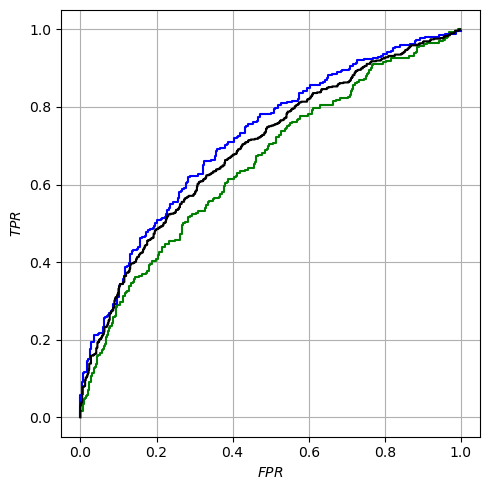

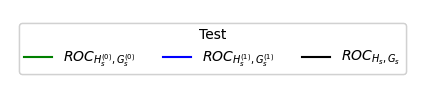

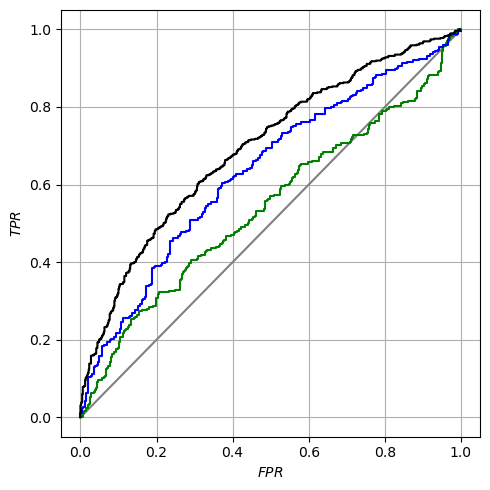

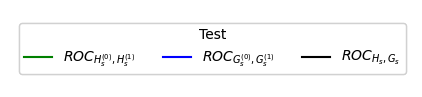

In [26]:
bpsn_model = load_model("auc_cons_bpsn")

# we hardcode a folder where the results are saved
exp_path = pathlib.Path("./output/compas_auc")

if not exp_path.exists():
    exp_path.mkdir(parents=True, exist_ok=True)

# need to close an eventually already existing tenserflow session properly as we can't fit another model otherwise
tf.compat.v1.reset_default_graph()

time_2 = datetime.datetime.now()
bpsn_model.fit(data_train) # I didn't include the optional parameter about the model folder as I just created a new instance.
time_3 = datetime.datetime.now()

# Write a logging file with important info
with (exp_path / "log.txt").open("wt") as f:
    f.write("db_name: {}\n".format("adult"))
    f.write("time_to_load: {}\n".format(time_2-time_1))
    f.write("time_to_fit: {}\n".format(time_3-time_2))

# Save the model
bpsn_model.save_model(exp_path)

s_test = np.array(bpsn_model.score(X_test)).ravel().astype(float)
s_train = np.array(bpsn_model.score(X_train)).ravel().astype(float)

# Define a path on where to save the results
path_analysis = pathlib.Path("./evaluation/compas_auc")

if not path_analysis.exists():
        path_analysis.mkdir(parents=True, exist_ok=True)

# 1. Plot ROC curves for all problems on the same plot
plot_roc_sec3(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Other view on ROCs
plot_roc_sec4(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

## 2.2 ROC based fairness

Vogel et al. (2021) say that the results from the AUC-constraint look quite good. The results from my scoring function with ROC-based constraint differ each run and do not necessarily look better than those from with AUC constraint. But usually, especially in the higher areas there can be seen a lot of equivalences to figure 3f) in the paper.

Parameters:
mon_pts : {-1: [0.25], 1: [0.25]}
adapt_step_t : 0.01
n_iter : 150000
n_batch : 1000
display_step : 10000
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0
Number of features: 16
Size of the train set: 4443
Size of the validation set: 494


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Iter   0   ---------- 10/5/24 - 15:11:6 -----
Iter 10000 ---------- 10/5/24 - 15:11:14 -----
Iter 20000 ---------- 10/5/24 - 15:11:22 -----
Iter 30000 ---------- 10/5/24 - 15:11:30 -----
Iter 40000 ---------- 10/5/24 - 15:11:38 -----
Iter 50000 ---------- 10/5/24 - 15:11:46 -----
Iter 60000 ---------- 10/5/24 - 15:11:54 -----
Iter 70000 ---------- 10/5/24 - 15:12:2 -----
Iter 80000 ---------- 10/5/24 - 15:12:10 -----
Iter 90000 ---------- 10/5/24 - 15:12:18 -----
Iter 100000 ---------- 10/5/24 - 15:12:25 -----
Iter 110000 ---------- 10/5/24 - 15:12:33 -----
Iter 120000 ---------- 10/5/24 - 15:12:41 -----
Iter 130000 ---------- 10/5/24 - 15:12:49 -----
Iter 140000 ---------- 10/5/24 - 15:12:57 -----
Iter 149999 ---------- 10/5/24 - 15:13:4 -----
The AUC for the test (black ROC curve) set is: 0.704


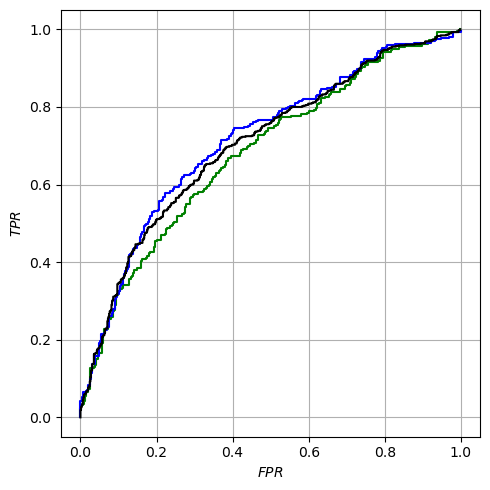

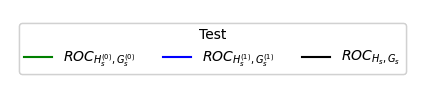

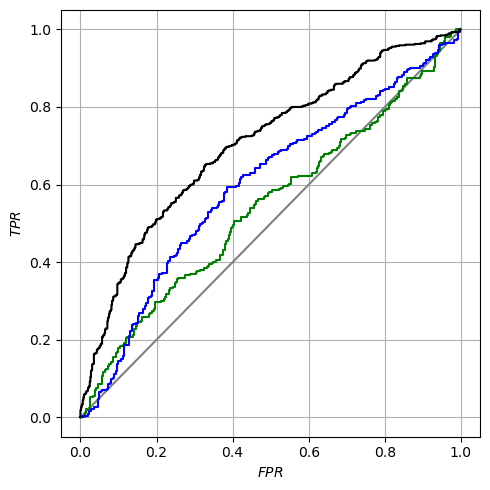

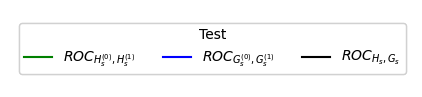

In [27]:
roc_model_compas = load_model("ptw_cons")

# we hardcode a folder where the results are saved
exp_path = pathlib.Path("./output/compas_roc")

if not exp_path.exists():
    exp_path.mkdir(parents=True, exist_ok=True)

# need to close an eventually already existing tenserflow session properly as we can't fit another model otherwise
tf.compat.v1.reset_default_graph()

time_2 = datetime.datetime.now()
roc_model_compas.fit(data_train) # I didn't include the optional parameter about the model folder as I just created a new instance.
time_3 = datetime.datetime.now()

# Write a logging file with important info
with (exp_path / "log.txt").open("wt") as f:
    f.write("db_name: {}\n".format("adult"))
    f.write("time_to_load: {}\n".format(time_2-time_1))
    f.write("time_to_fit: {}\n".format(time_3-time_2))

# Save the model
roc_model_compas.save_model(exp_path)

s_test = np.array(roc_model_compas.score(X_test)).ravel().astype(float)
s_train = np.array(roc_model_compas.score(X_train)).ravel().astype(float)

# Define a path on where to save the results
path_analysis = pathlib.Path("./evaluation/compas_roc")

if not path_analysis.exists():
        path_analysis.mkdir(parents=True, exist_ok=True)

# 1. Plot ROC curves for all problems on the same plot
plot_roc_sec3(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Other view on ROCs
plot_roc_sec4(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 3. German credit dataset

The plots for this dataset cannot be found in the main paper, but just in its supplement material. This dataset classifies people in whether they are having a low or high credit risk (Y), while the sensitive attribute is the gender (male of female).

In [28]:
time_1 = datetime.datetime.now()

data_train, data_test = load_db_by_name("german")
X_train, Y_train, Z_train = data_train
X_test, Y_test, Z_test = data_test

# Print the first few rows of each part of the data to verify it's loaded correctly
print("First few rows of X_train:")
print(X_train[:3])

print("\nFirst few values of Z_train (sensitive attributes):")
print(Z_train[:3])

print("\nFirst few labels of y_train:")
print(Y_train[:3])

print("\nFirst few rows of X_test:")
print(X_test[:3])

print("\nFirst few values of Z_test (sensitive attributes):")
print(Z_test[:3])

print("\nFirst few labels of y_test:")
print(Y_test[:3])

First few rows of X_train:
[[ 3.29708155  1.19991221  0.03119565  1.04450868  2.4061873   1.01777726
  -0.40973554  1.65478632 -0.60430763 -0.25543363 -0.82289054 -0.21389632
  -0.22331316 -1.05131497  3.15577314 -0.64298333 -0.55809982 -0.34251779
  -0.11250879 -0.45457288 -0.62747767 -0.11807497 -0.15597367 -0.22021079
  -0.09395338  3.02102338  0.82931521 -0.33794397 -0.27435163 -0.226381
  -0.47841263 -0.26904657 -0.44855457 -0.71374643 -0.46056619  1.72058015
  -0.21068086 -0.68205679  0.90453403 -0.31448545  0.33333333 -0.21068086
  -0.24699789 -0.61588176 -0.55424682 -0.7117523   2.34607439 -0.39716798
  -0.21389632  0.46852129 -0.46056619  0.62941287 -0.34931309 -0.14734777
  -0.48038446  0.76430257 -0.43643578 -1.1751393   1.1751393   0.19044535
  -0.19044535]
 [-0.00805096 -0.35962991 -0.86010854 -1.67144022 -0.22436411 -0.71093146
  -0.40973554 -0.60430763 -0.60430763  3.91491132 -0.82289054 -0.21389632
  -0.22331316 -1.05131497 -0.31687956  1.55525028 -0.55809982 -0.3425177

## 3.1 Background Negative Subgroup Positive (BNSP) AUC fairness

The plots corresponds to figure 11i) and 11j) in the paper.

The BNSP AUC fairness ensures that the probabilities that a positive from a given group is mistakenly ranked higher than a negative is the same across groups.

Parameters:
n_iter : 150000
n_batch : 1000
display_step : 10000
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0
Number of features: 61
Size of the train set: 720
Size of the validation set: 80


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Iter   0   ---------- 10/5/24 - 15:13:5 -----
Iter 10000 ---------- 10/5/24 - 15:13:19 -----
Iter 20000 ---------- 10/5/24 - 15:13:33 -----
Iter 30000 ---------- 10/5/24 - 15:13:47 -----
Iter 40000 ---------- 10/5/24 - 15:14:1 -----
Iter 50000 ---------- 10/5/24 - 15:14:15 -----
Iter 60000 ---------- 10/5/24 - 15:14:28 -----
Iter 70000 ---------- 10/5/24 - 15:14:42 -----
Iter 80000 ---------- 10/5/24 - 15:14:56 -----
Iter 90000 ---------- 10/5/24 - 15:15:10 -----
Iter 100000 ---------- 10/5/24 - 15:15:23 -----
Iter 110000 ---------- 10/5/24 - 15:15:37 -----
Iter 120000 ---------- 10/5/24 - 15:15:51 -----
Iter 130000 ---------- 10/5/24 - 15:16:5 -----
Iter 140000 ---------- 10/5/24 - 15:16:19 -----
Iter 149999 ---------- 10/5/24 - 15:16:32 -----
The AUC for the test (black ROC curve) set is: 0.777


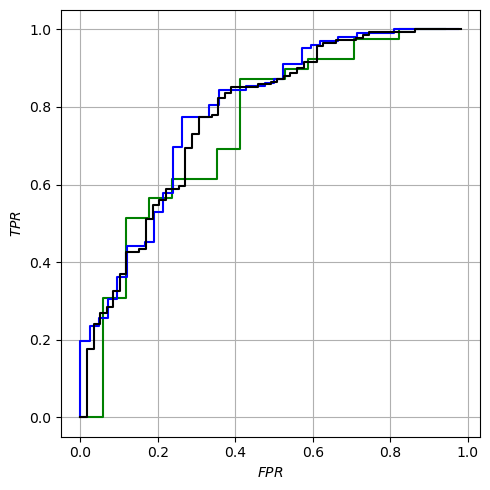

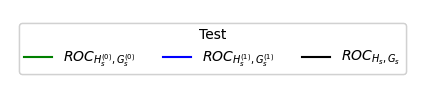

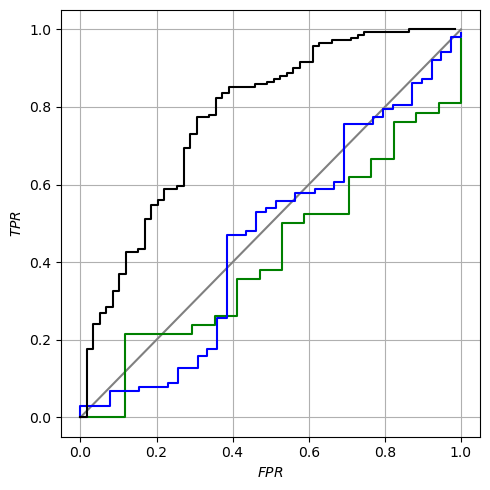

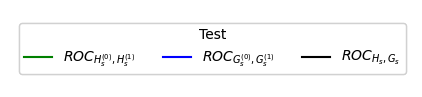

In [29]:
bnsp_model_credit = load_model("auc_cons_bnsp")

# we hardcode a folder where the results are saved
exp_path = pathlib.Path("./output/german_auc")

if not exp_path.exists():
    exp_path.mkdir(parents=True, exist_ok=True)

# need to close an eventually already existing tenserflow session properly as we can't fit another model otherwise
tf.compat.v1.reset_default_graph()

time_2 = datetime.datetime.now()
bnsp_model_credit.fit(data_train) # I didn't include the optional parameter about the model folder as I just created a new instance.
time_3 = datetime.datetime.now()

# Write a logging file with important info
with (exp_path / "log.txt").open("wt") as f:
    f.write("db_name: {}\n".format("german"))
    f.write("time_to_load: {}\n".format(time_2-time_1))
    f.write("time_to_fit: {}\n".format(time_3-time_2))

# Save the model
bnsp_model_credit.save_model(exp_path)

s_test = np.array(bnsp_model_credit.score(X_test)).ravel().astype(float)
s_train = np.array(bnsp_model_credit.score(X_train)).ravel().astype(float)

# Define a path on where to save the results
path_analysis = pathlib.Path("./evaluation/german_auc")

if not path_analysis.exists():
        path_analysis.mkdir(parents=True, exist_ok=True)

# 1. Plot ROC curves for all problems on the same plot
plot_roc_sec3(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Other view on ROCs
plot_roc_sec4(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

## 3.2 ROC based fairness

The plots corresponds to figure 11k) and 11l) in the paper.

Parameters:
mon_pts : {-1: [0.25], 1: [0.25]}
adapt_step_t : 0.01
n_iter : 150000
n_batch : 1000
display_step : 10000
lr : 0.001
adapt_step : 0.01
momentum : 0.9
default_c : 0.0
default_var_init : 0.01
reg : 0.001
optimizer : momentum
weight_fun : softmax
cooling_c : 0
balanced : 0
validation_size : 0.1
coef_lagrange : 1.0
net_depth : 3
use_inc_auc_train : 1
n_incomplete_train : 1000
use_inc_auc_valid : 1
n_incomplete_valid : 10000
c : 0.0
Number of features: 61
Size of the train set: 720
Size of the validation set: 80


/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/opt/anaconda3/envs/fml_tf_env_v2/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Iter   0   ---------- 10/5/24 - 15:16:33 -----
Iter 10000 ---------- 10/5/24 - 15:16:46 -----
Iter 20000 ---------- 10/5/24 - 15:16:59 -----
Iter 30000 ---------- 10/5/24 - 15:17:12 -----
Iter 40000 ---------- 10/5/24 - 15:17:25 -----
Iter 50000 ---------- 10/5/24 - 15:17:37 -----
Iter 60000 ---------- 10/5/24 - 15:17:50 -----
Iter 70000 ---------- 10/5/24 - 15:18:3 -----
Iter 80000 ---------- 10/5/24 - 15:18:16 -----
Iter 90000 ---------- 10/5/24 - 15:18:29 -----
Iter 100000 ---------- 10/5/24 - 15:18:42 -----
Iter 110000 ---------- 10/5/24 - 15:18:55 -----
Iter 120000 ---------- 10/5/24 - 15:19:8 -----
Iter 130000 ---------- 10/5/24 - 15:19:20 -----
Iter 140000 ---------- 10/5/24 - 15:19:33 -----
Iter 149999 ---------- 10/5/24 - 15:19:46 -----
The AUC for the test (black ROC curve) set is: 0.782


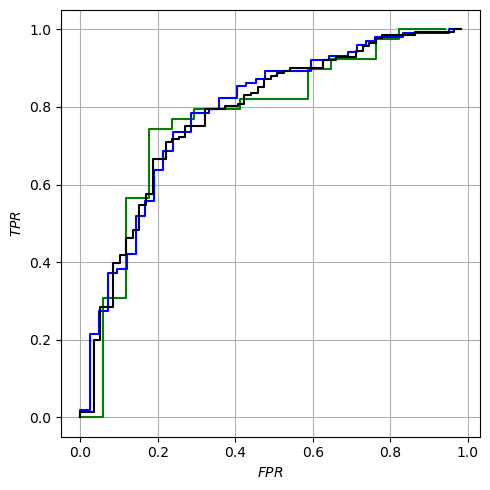

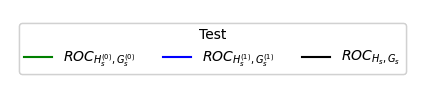

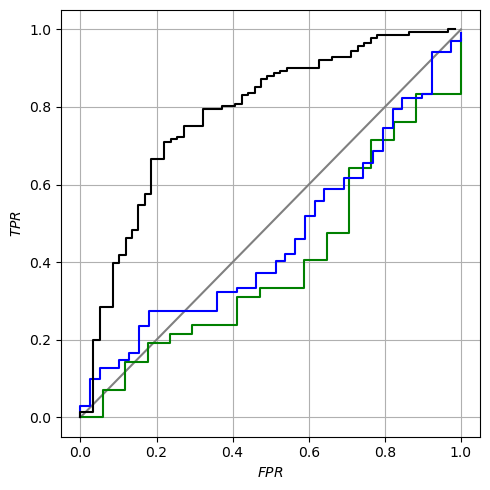

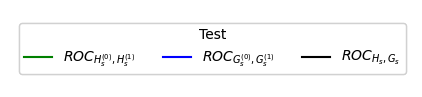

In [30]:
roc_model_credit = load_model("ptw_cons")

# we hardcode a folder where the results are saved
exp_path = pathlib.Path("./output/german_roc")

if not exp_path.exists():
    exp_path.mkdir(parents=True, exist_ok=True)

# need to close an eventually already existing tenserflow session properly as we can't fit another model otherwise
tf.compat.v1.reset_default_graph()

time_2 = datetime.datetime.now()
roc_model_credit.fit(data_train) # I didn't include the optional parameter about the model folder as I just created a new instance.
time_3 = datetime.datetime.now()

# Write a logging file with important info
with (exp_path / "log.txt").open("wt") as f:
    f.write("db_name: {}\n".format("german"))
    f.write("time_to_load: {}\n".format(time_2-time_1))
    f.write("time_to_fit: {}\n".format(time_3-time_2))

# Save the model
roc_model_credit.save_model(exp_path)

s_test = np.array(roc_model_credit.score(X_test)).ravel().astype(float)
s_train = np.array(roc_model_credit.score(X_train)).ravel().astype(float)

# Define a path on where to save the results
path_analysis = pathlib.Path("./evaluation/german_roc")

if not path_analysis.exists():
        path_analysis.mkdir(parents=True, exist_ok=True)

# 1. Plot ROC curves for all problems on the same plot
plot_roc_sec3(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 2. Other view on ROCs
plot_roc_sec4(path_analysis,
                (s_train, Y_train, Z_train), (s_test, Y_test, Z_test))

# 4. Concluding comments

This notebook has shown that with certain adjustments of the code from Vogel et al. (2021), it is possible to indeed use their models also in a simpler setup and to make it run in a Jupyter Notebook.

The generated plots (some of them a little more, others a little less) are similar to those from the papers. Deviations are likely resulting from different parameters and hyperparameters as well as some randomness.

Therefore, I suggest conducting different experiments in a next step. That might include the following:
- Hyperparameter tuning: reaching from the learning rate, batch size and number of iterations to the custom hyperparameters of the model
- It would be interesting to try out further datasets and to see how suitable they are
- It would be necessary to look not only at how fair the algorithms are but also how performant
- Finding out about the cost (in reduced performance) of the models would be interesting
- And there are many more ...